# IBM Data Science Professional Certificate
# Capstone project
# Determining the suitability of neighborhoods for particular cuisines
# Three methods and three metrics

# 1. Scraping Wikipedia page for information on Toronto neighborhoods

Each major step of the process will be under a sub-heading. The answer to the questions will be marked down with a level 1 heading. Each step is in a different cell. Some cells are optional and will be marked as such.

## Installing libraries (optional)

This step installs the libraries necessary to run the notebook. If you already have these installed, you can and should skip running this cell. The libraries are:
* Beautifulsoup, this is used for parsing the html from wikipedia, although we will soon handover to pandas
* Geopy is used for geolocation
* Folium is used for map visualization

In [ ]:
!conda install -c conda-forge beautifulsoup4 --yes

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

## Importing

Always run this cell. We are importing all the libraries that will be used including beautifulsoup, numpy, pandas, folium, and sklearn among others. If any of the import conditions yield an error, you need to install the corresponding library first using !pip. Within the rest of the notebook, we will import additional libraries and components of libraries as needed. Make sure to run these cells as well.

In [1]:
import numpy as np
import pandas as pd

import requests

import requests
from pandas.io.json import json_normalize
import json

import matplotlib.cm as cm

import matplotlib.colors as colors


from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium


import sklearn
from sklearn.cluster import KMeans

## Create a soup object

In this step, we create a handle for the text contents of the link to the html page and pass it to beautiful soup. This creates an object of type bs4.BeautifulSoup. If you try printing its contents with the .text() method, you will find a very raw form of the html on the page.

In [2]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url, 'html.parser')

This code segment creates empty lists that will later be populated by data from the table

In [3]:
postalcodes = []
boroughs = []
neighborhoods = []


The cell below performs the parsing. Comments indicate what is happening.

In [4]:
# This loop will scour the soup object line by line to find where the first table starts
# It is actually looking for an html tag rather than the specific string
# It then looks for and returns all elements in the table with tag <tr> which indicates a table row
# We then extract any entry with a tage <td> which indicates a normal table cell entry
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    #print(row)
    #print(cells)
    if(len(cells) > 0):
        # The above check avoids scouring formatting and empty rows
        #print(cells[0].text)
        postalcodes.append(cells[0].text.replace("\n",""))
        boroughs.append(cells[1].text.replace("\n",""))
        neighborhoods.append(cells[2].text.replace("\n",""))
        # We populate the three empty lists with the elements of the table
        # We have to use the replace method because for some reason each entry includes an extra carriage return
        # Without the replace method, my table has an extra \n literal added to the string
        
#print(postalCodeList)
#print(boroughList)
#print(neighborhoodList)

## Forming the main data frame with Toronto geographical information

The upcoming cells will create the main geographical information data frame we will be using for the rest of the problem. In the first step we create a dictionary of labels and corresponding values for postalcodes, boroughs, and neighborhoods. There are three dictionary keys and the values corresponding to the three keys are the lists we populated above using the soup method.

While a dictionary may not seem like an immediately suitable data structure here, there is a reason we use it. If you try printing the dictionary (there is a commented line to do this), you will find that the entries look counter intuitive and not very instructive. There is a very short string key corresponding to an extremely long value list. However, the DataFrame.from_dict() method is why we are doing this. The method takes in the dictionary and creates a data frame where the keys are the column headings and the lists are the values.

We print a header for the dataframe as a quick check that we did not mess up the formatting. This is something we will be doing after every significant step that changes our main dataframe.

In [5]:
# We create a dictionary of three lists we created. This allows us to use a special pandas method to create the frame

n_dict = {'PostalCode': postalcodes,
                      'Borough': boroughs,
                      'Neighborhood': neighborhoods}
#print(n_dict)
df = pd.DataFrame.from_dict(n_dict)
# As a sanity check print a long header
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


Next is inital cleanup. We are required to remove all entries which do not have a Borough value. This is indicated by the value 'Not assigned' in the frame. The default pandas method will act on field values of 'na'. However, we can create a new frame where the 'Not assigned' fields are dropped. This cannot be done in place, so we create a new frame called toronto_df_nona. As always, we print a header to check, although in this case this is not an exhaustive check.

In [6]:
toronto_df_nona = df[df.Borough != 'Not assigned'].reset_index(drop=True)
toronto_df_nona.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
toronto_df_grouped = toronto_df_nona.groupby(['PostalCode','Borough'], as_index=False).agg(lambda x: ','.join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
na_neigh_rows = toronto_df_grouped.Neighborhood == 'Not assigned'
toronto_df_grouped.loc[na_neigh_rows, 'Neighborhood'] = toronto_df_grouped.loc[na_neigh_rows, 'Borough']
toronto_df_grouped[na_neigh_rows]
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
toronto_df_cleaned = toronto_df_grouped
toronto_df_cleaned.shape

(103, 3)

As seen above the frame has 103 entries. There are three columns in the frame for postal code, borough, and neighborhood. The key of the frame is PostalCode, although we have not yet specified this.

___
# 2. Getting coordinates and merging the frames

Either download the file from the attached URL then load it using .read_csv() or uncommet the !wget commands and obtain it from the provided link. As always, the first thing we do is get to know the data. We do this by getting familiar with its shape and taking a look at the first few records.

In [106]:
#!pip install wget
import wget
#!wget -q -O "toronto_coordinates.csv" http://cocl.us/Geospatial_data
#!wget --quiet https://cocl.us/sanfran_geojson -O sf_geo.json    
coordinates = pd.read_csv('Geospatial_Coordinates.csv')

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [11]:
print(coordinates.shape)
coordinates.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:

toronto_df_temp = toronto_df_cleaned.set_index('PostalCode')
coors_temp = coordinates.set_index('Postal Code')
toronto_df_coors = pd.concat([toronto_df_temp, coors_temp], axis=1, join='inner')

In [13]:
toronto_df_coors.index.name = 'PostalCode'
toronto_df_coors.reset_index(inplace=True)

In [14]:
print(toronto_df_coors.shape)
toronto_df_coors.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Above, we define indices for both frames as the PostalCode column. This allows us to merge the frame containing name information with the frame containing latitude and longitude by the common field: postal code. We use the concat method although the merge method would also work. As always, we use shape and head to get a first look at the data. This always works as a sanity check.

# 3. First reduction

This section reduces the number of entries in the frame by only considering neighborhoods with the name Toronto in them. We end up with 39 entries corresponding to 39 distinct postal codes, all beginning with "M".

In [15]:
toronto_boroughs = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']
toronto_central_df = toronto_df_coors[toronto_df_coors['Borough'].isin(toronto_boroughs)].reset_index(drop=True)
print(toronto_central_df.shape)
toronto_central_df.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [16]:
toronto_central_df.head(39)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


# 4. Getting economic and demographic indicators and assimilating them

This section will read economic and population data and integrate it with the df_econ frame to create our master data frame. We first import the data either from the URL or by downloading it and using .read_csv(). The sources for this data are provided in the report. We begin by displaying the header.

We notice that column names are cumbersome and contain special characters that can make writing Python harder, so we rename most of the columns. There is also a problem with the PostalCode column name, which is critical to fix since it is the key.

We then display the header as a sanity check and merge the econ frame with toronto_central frame to create a merged frame. This df_merged frame will be our master frame for the majority of the rest of the notebook. We display preliminary statistics about all the columns and procedd to mark PostalCode as the key. We create a copy of PostalCode as well since we will need it as an iterable at a later point.

In [ ]:
#!pip install wget
import wget
#!wget -q -O "toronto_coordinates.csv" http://cocl.us/Geospatial_data
#!wget --quiet https://cocl.us/sanfran_geojson -O sf_geo.json    
df_econ = pd.read_csv('Toronto_economic_df.csv')

In [18]:
df_econ.head(39)

,Unnamed: 0,Taxable income ($Bln),Population,Income per capita
0,M4E,1.36000,25044,54.304424
1,M4K,1.36000,31583,43.061140
2,M4L,1.34000,32640,41.053922
3,M4M,0.89000,24689,36.048443
4,M4N,2.31000,15330,150.684932
5,M4P,0.96000,20039,47.906582
6,M4R,1.07000,11394,93.909075
7,M4S,1.42000,26506,53.572776
8,M4T,1.50000,10463,143.362324
9,M4V,2.10000,18241,115.125267


In [19]:
df_econ.rename(columns={'Unnamed: 0': 'PostalCode', 'Taxable income ($Bln)': 'Income', 'Income per capita': 'per_capita'}, inplace=True)

In [20]:
df_econ.head()

,PostalCode,Income,Population,per_capita
0,M4E,1.36,25044,54.304424
1,M4K,1.36,31583,43.061140
2,M4L,1.34,32640,41.053922
3,M4M,0.89,24689,36.048443
4,M4N,2.31,15330,150.684932


In [21]:
df_merged=pd.merge(df_econ, toronto_central_df, on = 'PostalCode')

In [22]:
df_merged.head()

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude
0,M4E,1.36,25044,54.304424,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,1.36,31583,43.061140,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,1.34,32640,41.053922,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,0.89,24689,36.048443,East Toronto,Studio District,43.659526,-79.340923
4,M4N,2.31,15330,150.684932,Central Toronto,Lawrence Park,43.728020,-79.388790


In [23]:
df_merged.describe()

,Income,Population,per_capita,Latitude,Longitude
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,1.038136,19540.153846,182.031957,43.667135,-79.389873
std,0.691447,13945.151703,642.348226,0.023478,0.037451
min,0.000000,0.000000,0.000000,43.628947,-79.484450
25%,0.470000,9790.500000,33.332915,43.649765,-79.405678
50%,1.070000,18241.000000,47.906582,43.662301,-79.387383
75%,1.390000,31027.500000,87.893731,43.677957,-79.376474
max,2.450000,49195.000000,4000.000000,43.728020,-79.293031


In [24]:
df_merged.describe(include='all')

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude
count,39,39.000000,39.000000,39.000000,39,39,39.000000,39.000000
unique,39,NaN,NaN,NaN,4,39,NaN,NaN
top,M5P,NaN,NaN,NaN,Downtown Toronto,"Forest Hill North & West, Forest Hill Road Park",NaN,NaN
freq,1,NaN,NaN,NaN,19,1,NaN,NaN
mean,NaN,1.038136,19540.153846,182.031957,NaN,NaN,43.667135,-79.389873
std,NaN,0.691447,13945.151703,642.348226,NaN,NaN,0.023478,0.037451
min,NaN,0.000000,0.000000,0.000000,NaN,NaN,43.628947,-79.484450
25%,NaN,0.470000,9790.500000,33.332915,NaN,NaN,43.649765,-79.405678
50%,NaN,1.070000,18241.000000,47.906582,NaN,NaN,43.662301,-79.387383
75%,NaN,1.390000,31027.500000,87.893731,NaN,NaN,43.677957,-79.376474


In [25]:
df_merged.set_index('PostalCode', inplace=True, drop=False)

# 5. Getting Foursquare data and assimilating into final data frame

This is the final step in data acquisition. We will be obtaining counts of restaurants belonging to different world cuisines for each of the 39 postal codes in our frame. Notice that there is nothing special about the number 39 and the code will work just as well if we expand the number of entries in the main data frame.

We being by defining a list of world cuisines we want to discover. This can be modified or extended by the user at will. We then define credentials for login to Foursquare. We add a column representing each of the cuisines to the master frame df_merged.

The heart of this section is a nested for loop. The outer loop will iterate through the world cuisines. The inner loop iterates through each row of the data frame. For each entry and cuisines combination, we make a Foursquare API call with the correct query. From the returned JSON object, we obtain the total number of hits, which represents the total number of restaurants found from the specified cuisine. Notice that the radius variable can be changed by the user to include a larger area around the center of the postal code.

This data is saved in the master frame. It will take some time for this loop to execute, and it may fail due to exceeding quotas because of the large number of queries made. The results are thus pushed to a csv file to allow the rest of the code to be rerun without needing to run everything in this section.

In [26]:
# Define our list of cuisines
cuisines=['Italian', 'Indian', 'Chinese', 'Japanese', 'Korean', 'French', 'Greek', 'Peruvian', 'Brazilian', 'Mexican', 'Spanish', 'German', 'Moroccan', 'Egyptian', 'Turkish', 'Persian', 'Thai']
#cuisines=['Italian']

In [27]:
# Preparing Foursquare connection
CLIENT_ID = '20BDBJM2RIGFPVT5L4PL2UW3TXRHVCKGU1GHCPMONFR4IHZH' # your Foursquare ID
CLIENT_SECRET = 'HKVHQUZEU02L52EMRWBFGVQEBAGHSIC0YCO1FTWS2BBNI2HY' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius=500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 20BDBJM2RIGFPVT5L4PL2UW3TXRHVCKGU1GHCPMONFR4IHZH
CLIENT_SECRET:HKVHQUZEU02L52EMRWBFGVQEBAGHSIC0YCO1FTWS2BBNI2HY


In [28]:
# Setting query and radius
#search_query = 'k'
#radius = 500
#print(search_query + ' .... OK!')

In [29]:
for cuisine in cuisines:
    df_merged.insert(df_merged.shape[1],cuisine, [0]*df_merged.shape[0])
df_merged.head()

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude,Italian,Indian,...,Peruvian,Brazilian,Mexican,Spanish,German,Moroccan,Egyptian,Turkish,Persian,Thai
PostalCode,,,,,,,,,,,,,,,,,,,,,
M4E,M4E,1.36,25044,54.304424,East Toronto,The Beaches,43.676357,-79.293031,0,0,...,0,0,0,0,0,0,0,0,0,0
M4K,M4K,1.36,31583,43.061140,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0,...,0,0,0,0,0,0,0,0,0,0
M4L,M4L,1.34,32640,41.053922,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,0,...,0,0,0,0,0,0,0,0,0,0
M4M,M4M,0.89,24689,36.048443,East Toronto,Studio District,43.659526,-79.340923,0,0,...,0,0,0,0,0,0,0,0,0,0
M4N,M4N,2.31,15330,150.684932,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_merged.head()

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude,Italian,Indian,...,Peruvian,Brazilian,Mexican,Spanish,German,Moroccan,Egyptian,Turkish,Persian,Thai
PostalCode,,,,,,,,,,,,,,,,,,,,,
M4E,M4E,1.36,25044,54.304424,East Toronto,The Beaches,43.676357,-79.293031,0,0,...,0,0,0,0,0,0,0,0,0,0
M4K,M4K,1.36,31583,43.061140,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0,...,0,0,0,0,0,0,0,0,0,0
M4L,M4L,1.34,32640,41.053922,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,0,...,0,0,0,0,0,0,0,0,0,0
M4M,M4M,0.89,24689,36.048443,East Toronto,Studio District,43.659526,-79.340923,0,0,...,0,0,0,0,0,0,0,0,0,0
M4N,M4N,2.31,15330,150.684932,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, round(lat,2), round(long,2), VERSION, search_query, radius, LIMIT)

#results = requests.get(url).json()
#print(results)

In [31]:
print(cuisines)
for cuisine in cuisines:
    search_query=cuisine
    for lat, long, post, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['PostalCode'], df_merged['Borough'], df_merged['Neighborhood']):
        #print(type(lat))
        #print(type(long))
        #print(lat)
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, round(lat,2), round(long,2), VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        print(results)
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        #dataframe.head()
        #dataframe.shape[0]
        print(dataframe.shape[0])
        #print(dataframe.shape[0])
        df_merged.at[post,cuisine]=dataframe.shape[0]
        print(df_merged[cuisine][post])
    print ("Finished cuisine "+cuisine)
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
#url


['Italian', 'Indian', 'Chinese', 'Japanese', 'Korean', 'French', 'Greek', 'Peruvian', 'Brazilian', 'Mexican', 'Spanish', 'German', 'Moroccan', 'Egyptian', 'Turkish', 'Persian', 'Thai']
{'meta': {'code': 200, 'requestId': '5ef6dc4fd24a36121e4bb90a'}, 'response': {'venues': []}}
0
0


/Users/karimabbas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':


{'meta': {'code': 200, 'requestId': '5ef6ddce21cdee79b0d6f6f9'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcf2d0415c07c632d946'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcc947efc372b91b289c'}, 'response': {'venues': [{'id': '5ad12ca2345cbe490eb125e5', 'name': 'Frankie’s Italian', 'location': {'address': '892 Queen Street West', 'lat': 43.660411, 'lng': -79.343097, 'labeledLatLngs': [{'label': 'display', 'lat': 43.660411, 'lng': -79.343097}], 'distance': 253, 'postalCode': 'M4M 1J3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['892 Queen Street West', 'Toronto ON M4M 1J3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236706', 'hasPerk': Fals

{'meta': {'code': 200, 'requestId': '5ef6dc8a8d58ab258e53a041'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd0927946d5a14c9d08d'}, 'response': {'venues': [{'id': '53daae5b498e9c9597c19b23', 'name': "john's italian cafe", 'location': {'address': '27 Baldwin Street', 'lat': 43.656126727987754, 'lng': -79.39330107245038, 'labeledLatLngs': [{'label': 'display', 'lat': 43.656126727987754, 'lng': -79.39330107245038}], 'distance': 506, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['27 Baldwin Street', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236713', 'hasPerk': False}, {'id': '51bf3866498e55ee55df8db0', 'name': 'The Fresh Italian', 'location': {'lat': 43.65499143746

{'meta': {'code': 200, 'requestId': '5ef6dcc5cd0a802e7643398b'}, 'response': {'venues': [{'id': '5b897e92db1d81002c91df8c', 'name': 'Fabbrica Rustic Italian', 'location': {'address': '66 Wellington St W', 'lat': 43.647161, 'lng': -79.381691, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647161, 'lng': -79.381691}], 'distance': 344, 'postalCode': 'M5K 1E7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['66 Wellington St W', 'Toronto ON M5K 1E7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236715', 'hasPerk': False}, {'id': '4c787c9181bca0936180fa14', 'name': 'Classic italian style pizza food truck', 'location': {'address': 'CNE Midway', 'lat': 43.652144, 'lng': -79.381118, 'labeledLatLngs': [{'label': '

{'meta': {'code': 200, 'requestId': '5ef6db912f5bc4555b52caa9'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db52a50d067df90d106d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcd3e771111ff8cfdd79'}, 'response': {'venues': [{'id': '5b897e92db1d81002c91df8c', 'name': 'Fabbrica Rustic Italian', 'location': {'address': '66 Wellington St W', 'lat': 43.647161, 'lng': -79.381691, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647161, 'lng': -79.381691}], 'distance': 344, 'postalCode': 'M5K 1E7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['66 Wellington St W', 'Toronto ON M5K 1E7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236719', 'hasPerk': Fals

{'meta': {'code': 200, 'requestId': '5ef6dd2fe9e7ad15129501e0'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6daa383d66d03124db370'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dae8faaa5e71d3929a72'}, 'response': {'venues': [{'id': '4df3f7cd62e1288ed306075d', 'name': 'Indian Record Shop', 'location': {'address': '1426 Gerrard Street East', 'lat': 43.67190504224122, 'lng': -79.32198986064832, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67190504224122, 'lng': -79.32198986064832}], 'distance': 265, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1426 Gerrard Street East', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10d951735', 'name': 'Record Shop', 'pluralName': 'Record Shops', 'shortName': 'Record Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/record_shop_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236725', 'hasPerk': Fal

{'meta': {'code': 200, 'requestId': '5ef6dc7e882fc7644ea298c1'}, 'response': {'venues': [{'id': '4c6e9aff65eda0934edc51d0', 'name': 'Ontario Federation of Indigenous Friendship Centres', 'location': {'address': '219 Front St. E', 'lat': 43.65079829197435, 'lng': -79.36559927695984, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65079829197435, 'lng': -79.36559927695984}], 'distance': 459, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['219 Front St. E', 'Toronto ON', 'Canada']}, 'categories': [], 'referralId': 'v-1593236731', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dca107a2fd0bac2ae5ba'}, 'response': {'venues': [{'id': '5165c333e4b07a7ad88d8a69', 'name': "Joe's Indian Restaurant", 'location': {'lat': 43.65814977325445, 'lng': -79.38156263736568, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65814977325445, 'lng': -79.38156263736568}], 'distance': 241, 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Canada'

{'meta': {'code': 200, 'requestId': '5ef6dc3004a5484389339a7f'}, 'response': {'venues': [{'id': '4fea497c121d2480d3579412', 'name': 'Indian Biriyani House', 'location': {'address': '120 Adelaide Street West', 'crossStreet': 'at Bay Street', 'lat': 43.650050280518336, 'lng': -79.38066244125366, 'labeledLatLngs': [{'label': 'display', 'lat': 43.650050280518336, 'lng': -79.38066244125366}], 'distance': 53, 'postalCode': 'M5H 3V1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['120 Adelaide Street West (at Bay Street)', 'Toronto ON M5H 3V1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236733', 'hasPerk': False}, {'id': '4d137f8c7a8ba1433cb3d169', 'name': 'Touch - Indian Cuisine', 'location': {'address': '1 Adelaid

{'meta': {'code': 200, 'requestId': '5ef6dc2f4cb2e80ec6510bc1'}, 'response': {'venues': [{'id': '4fea497c121d2480d3579412', 'name': 'Indian Biriyani House', 'location': {'address': '120 Adelaide Street West', 'crossStreet': 'at Bay Street', 'lat': 43.650050280518336, 'lng': -79.38066244125366, 'labeledLatLngs': [{'label': 'display', 'lat': 43.650050280518336, 'lng': -79.38066244125366}], 'distance': 53, 'postalCode': 'M5H 3V1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['120 Adelaide Street West (at Bay Street)', 'Toronto ON M5H 3V1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236735', 'hasPerk': False}, {'id': '4d137f8c7a8ba1433cb3d169', 'name': 'Touch - Indian Cuisine', 'location': {'address': '1 Adelaid

{'meta': {'code': 200, 'requestId': '5ef6db1c6e5c0a464854c5f1'}, 'response': {'venues': [{'id': '4fea497c121d2480d3579412', 'name': 'Indian Biriyani House', 'location': {'address': '120 Adelaide Street West', 'crossStreet': 'at Bay Street', 'lat': 43.650050280518336, 'lng': -79.38066244125366, 'labeledLatLngs': [{'label': 'display', 'lat': 43.650050280518336, 'lng': -79.38066244125366}], 'distance': 53, 'postalCode': 'M5H 3V1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['120 Adelaide Street West (at Bay Street)', 'Toronto ON M5H 3V1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236738', 'hasPerk': False}, {'id': '4d137f8c7a8ba1433cb3d169', 'name': 'Touch - Indian Cuisine', 'location': {'address': '1 Adelaid

{'meta': {'code': 200, 'requestId': '5ef6db1cb5ad90183fefe33f'}, 'response': {'venues': [{'id': '5019cebfe4b023c91d881f70', 'name': 'Indian road', 'location': {'address': 'Indian Road', 'crossStreet': 'Boustead Avenue', 'lat': 43.652361718573275, 'lng': -79.45571787358324, 'labeledLatLngs': [{'label': 'display', 'lat': 43.652361718573275, 'lng': -79.45571787358324}], 'distance': 433, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Indian Road (Boustead Avenue)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1f9931735', 'name': 'Road', 'pluralName': 'Roads', 'shortName': 'Road', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/highway_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236741', 'hasPerk': False}, {'id': '53fa9674498e0d297f35dd9e', 'name': 'Indian Mound Traffic Island', 'location': {'lat': 43.653977, 'lng': -79.457034, 'labeledLatLngs': [{'label': 'display', 'lat': 43.653977, 'lng': -79

{'meta': {'code': 200, 'requestId': '5ef6db6dd76da77399c6de3c'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbd7042e2d70f1303448'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db4e353f133543a7310b'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcbac12be54ba23b253b'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db89513bb60f51876767'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd084348d913c62799b7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db866c350d4925d18f7d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd3c587699312db65a2e'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db71d76da77399c6e5f5'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc7bd24a36121e4c1c6d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'reques

{'meta': {'code': 200, 'requestId': '5ef6ddec564b600a12bcf944'}, 'response': {'venues': [{'id': '4ae33054f964a520759121e3', 'name': 'Pearl Harbourfront', 'location': {'address': '200-207 Queens Quay W.', 'lat': 43.63815654013541, 'lng': -79.38068763743328, 'labeledLatLngs': [{'label': 'display', 'lat': 43.63815654013541, 'lng': -79.38068763743328}], 'distance': 212, 'postalCode': 'M5J 1A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['200-207 Queens Quay W.', 'Toronto ON M5J 1A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236752', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6db74a50d067df90d5ca9'}, 'response': {'venues': [{'id': '5202d246498e9649c88150b7', 'name': 'Toronto Chinese Ac

{'meta': {'code': 200, 'requestId': '5ef6dcec28da647940676514'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db77a50d067df90d64c0'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd3527946d5a14ca325a'}, 'response': {'venues': [{'id': '5202d246498e9649c88150b7', 'name': 'Toronto Chinese Academy', 'location': {'address': '133 Richmond Street West', 'crossStreet': 'York Street', 'lat': 43.65014006138457, 'lng': -79.38485690552969, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65014006138457, 'lng': -79.38485690552969}], 'distance': 391, 'postalCode': 'M5H 2L3', 'cc': 'CA', 'neighborhood': 'Financial District', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['133 Richmond Street West (York Street)', 'Toronto ON M5H 2L3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1ae941735', 'name': 'University', 'pluralName': 'Universities', 'shortName': 'University', 'icon': {'prefix': 'https://ss3.4sqi.net/img

{'meta': {'code': 200, 'requestId': '5ef6dd3b27946d5a14ca4161'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd3b27946d5a14ca4282'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcf6cd0a802e7643a830'}, 'response': {'venues': [{'id': '4ca609b0f47ea14346845c21', 'name': 'Ho Su Korean & Japanese Restaurant', 'location': {'lat': 43.71000214374543, 'lng': -79.39385634325662, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71000214374543, 'lng': -79.39385634325662}], 'distance': 310, 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Canada']}, 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236764', 'hasPerk': False}, {'id': '5ca7e70d829b0c002c304de8', 'name': '99 Sushi Japanese and Thai', 'location': {'lat': 43.7

{'meta': {'code': 200, 'requestId': '5ef6dc5504a548438933edd4'}, 'response': {'venues': [{'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647167, 'lng': -79.379608, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647167, 'lng': -79.379608}], 'distance': 316, 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236770', 'hasPerk': False}, {'id': '4af63562f964a5203d0222e3', 'name': 'Bikkuri Japanese', 'location': {'address': '36 King St. E', 'crossStreet': 'at Victoria', 'lat': 

{'meta': {'code': 200, 'requestId': '5ef6dc44a7f69f5c74791e9e'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd40ffc68c02664d405d'}, 'response': {'venues': [{'id': '4c12b8ba82a3c9b6083ffaf8', 'name': 'Mt. Fuji Japanese Restaurant', 'location': {'lat': 43.658555, 'lng': -79.384992, 'labeledLatLngs': [{'label': 'display', 'lat': 43.658555, 'lng': -79.384992}], 'distance': 434, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236771', 'hasPerk': False}, {'id': '5a62412b1108ba191da5ba06', 'name': 'KAKA', 'location': {'address': '655 Bay Street', 'crossStreet': '( Bay st & Elm st)', 'lat': 43.65745745164475, 'lng': -79.38419

{'meta': {'code': 200, 'requestId': '5ef6dd4427946d5a14ca563c'}, 'response': {'venues': [{'id': '57c76c1b498e26057391344c', 'name': "Uncle Tetsu's Japanese Cheesecake", 'location': {'lat': 43.64442750617172, 'lng': -79.38131123056226, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64442750617172, 'lng': -79.38131123056226}], 'distance': 504, 'postalCode': 'M5J', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Toronto ON M5J', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236772', 'hasPerk': False}, {'id': '501d4d55e4b0825080212f3c', 'name': 'Gonoe Sushi Japanese Restaurant', 'location': {'address': '262 Queens Quay W', 'lat': 43.63901430970685, 'lng': -79.38591360078077, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6390143097

{'meta': {'code': 200, 'requestId': '5ef6db2a4153fb4629a5500f'}, 'response': {'venues': [{'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647167, 'lng': -79.379608, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647167, 'lng': -79.379608}], 'distance': 316, 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236773', 'hasPerk': False}, {'id': '4af63562f964a5203d0222e3', 'name': 'Bikkuri Japanese', 'location': {'address': '36 King St. E', 'crossStreet': 'at Victoria', 'lat': 

{'meta': {'code': 200, 'requestId': '5ef6db2adba52f18853c5c4a'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd0ae771111ff8d059fc'}, 'response': {'venues': [{'id': '4b107e81f964a520b07123e3', 'name': 'EDO', 'location': {'address': '484 Eglinton Ave. W', 'crossStreet': 'btwn Heddington & Castleknock', 'lat': 43.703753667738965, 'lng': -79.41280203647945, 'labeledLatLngs': [{'label': 'display', 'lat': 43.703753667738965, 'lng': -79.41280203647945}], 'distance': 474, 'postalCode': 'M5N 1A2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['484 Eglinton Ave. W (btwn Heddington & Castleknock)', 'Toronto ON M5N 1A2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'venuePage': {'id': '38109205'}, 'referral

{'meta': {'code': 200, 'requestId': '5ef6dcd9c12be54ba23b6ba4'}, 'response': {'venues': [{'id': '4ae73054f964a5203ca921e3', 'name': 'Ki Modern Japanese + Bar', 'location': {'address': '181 Bay St', 'crossStreet': 'at Wellington St. W', 'lat': 43.647167, 'lng': -79.379608, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647167, 'lng': -79.379608}], 'distance': 316, 'postalCode': 'M5J 2T3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['181 Bay St (at Wellington St. W)', 'Toronto ON M5J 2T3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236777', 'hasPerk': False}, {'id': '4af63562f964a5203d0222e3', 'name': 'Bikkuri Japanese', 'location': {'address': '36 King St. E', 'crossStreet': 'at Victoria', 'lat': 

{'meta': {'code': 200, 'requestId': '5ef6dcc2bbdb0a49a6c508da'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db8da50d067df90d97f2'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc73f9762512a1a858e0'}, 'response': {'venues': [{'id': '56418c69498ec00425302f6a', 'name': 'Imanishi Japanese Kitchen', 'location': {'address': '1330 Dundas St W', 'crossStreet': 'at Rusholme Rd', 'lat': 43.649545622254195, 'lng': -79.42655051598773, 'labeledLatLngs': [{'label': 'display', 'lat': 43.649545622254195, 'lng': -79.42655051598773}], 'distance': 530, 'postalCode': 'M6J 1Y1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1330 Dundas St W (at Rusholme Rd)', 'Toronto ON M6J 1Y1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_

{'meta': {'code': 200, 'requestId': '5ef6dd1b48e3cc68615fac09'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dce1c12be54ba23b7fa7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcd807a2fd0bac2b620d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de0e564b600a12bd4816'}, 'response': {'venues': [{'id': '4e149f04aeb7727f2103eccd', 'name': 'Korean Ministry', 'location': {'address': '555 Avenue road', 'lat': 43.687128934197574, 'lng': -79.39963426037723, 'labeledLatLngs': [{'label': 'display', 'lat': 43.687128934197574, 'lng': -79.39963426037723}], 'distance': 320, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['555 Avenue road', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d12a941735', 'name': 'Capitol Building', 'pluralName': 'Capitol Buildings', 'shortName': 'Capitol Building', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/g

{'meta': {'code': 200, 'requestId': '5ef6dbb36c350d4925d1f627'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db9ba50d067df90db88c'}, 'response': {'venues': [{'id': '58f4e19067af3a223134f856', 'name': 'Koryo Korean Barbeque', 'location': {'address': '220 Yonge Street, F003, CF Toronto Eaton Centre', 'lat': 43.654438, 'lng': -79.380699, 'labeledLatLngs': [{'label': 'display', 'lat': 43.654438, 'lng': -79.380699}], 'distance': 497, 'postalCode': 'M5B 2H1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['220 Yonge Street, F003, CF Toronto Eaton Centre', 'Toronto ON M5B 2H1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236793', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, '

{'meta': {'code': 200, 'requestId': '5ef6dcd1f5be0232e5c85326'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dced1ec6724d86fc0a12'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd4dd0415c07c633a75a'}, 'response': {'venues': [{'id': '58f4e19067af3a223134f856', 'name': 'Koryo Korean Barbeque', 'location': {'address': '220 Yonge Street, F003, CF Toronto Eaton Centre', 'lat': 43.654438, 'lng': -79.380699, 'labeledLatLngs': [{'label': 'display', 'lat': 43.654438, 'lng': -79.380699}], 'distance': 497, 'postalCode': 'M5B 2H1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['220 Yonge Street, F003, CF Toronto Eaton Centre', 'Toronto ON M5B 2H1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5ef6dcec8d58ab258e547ebf'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc93f9762512a1a8a1af'}, 'response': {'venues': [{'id': '53c80eac498ec7a7ec92ecf9', 'name': 'French room', 'location': {'lat': 43.654596, 'lng': -79.387822, 'labeledLatLngs': [{'label': 'display', 'lat': 43.654596, 'lng': -79.387822}], 'distance': 626, 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Canada']}, 'categories': [{'id': '4d954b06a243a5684965b473', 'name': 'Residential Building (Apartment / Condo)', 'pluralName': 'Residential Buildings (Apartments / Condos)', 'shortName': 'Residential', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/apartment_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236811', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dd5c85bc7548a3667166'}, 'response': {'venues': [{'id': '4b11769ff964a520207d23e3', 'name': 'French Connection', 'location': {'address': '2

{'meta': {'code': 200, 'requestId': '5ef6dcfe1ec6724d86fc2ea6'}, 'response': {'venues': [{'id': '4b11769ff964a520207d23e3', 'name': 'French Connection', 'location': {'address': '250 Yonge St.', 'crossStreet': 'in Eaton Centre', 'lat': 43.65275017345691, 'lng': -79.3802257915263, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65275017345691, 'lng': -79.3802257915263}], 'distance': 306, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['250 Yonge St. (in Eaton Centre)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d103951735', 'name': 'Clothing Store', 'pluralName': 'Clothing Stores', 'shortName': 'Apparel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236813', 'hasPerk': False}, {'id': '4c2dff26e307d13aeab50eda', 'name': 'The French Press', 'location': {'lat': 43.648839, 'lng': -79.384944, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6

{'meta': {'code': 200, 'requestId': '5ef6dcc56174af1820ef5789'}, 'response': {'venues': [{'id': '4b11769ff964a520207d23e3', 'name': 'French Connection', 'location': {'address': '250 Yonge St.', 'crossStreet': 'in Eaton Centre', 'lat': 43.65275017345691, 'lng': -79.3802257915263, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65275017345691, 'lng': -79.3802257915263}], 'distance': 306, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['250 Yonge St. (in Eaton Centre)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d103951735', 'name': 'Clothing Store', 'pluralName': 'Clothing Stores', 'shortName': 'Apparel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236817', 'hasPerk': False}, {'id': '4c2dff26e307d13aeab50eda', 'name': 'The French Press', 'location': {'lat': 43.648839, 'lng': -79.384944, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6

{'meta': {'code': 200, 'requestId': '5ef6dc9a4f30dd22c570f7d7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcefbbdb0a49a6c56e15'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbbcd76da77399c78f24'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc7aa7f69f5c74799597'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbfb2f5bc4555b53b9db'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd4bf1f0896dbdd20495'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcbb32a8a96285738767'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de4721cdee79b0d8078d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcfc8d58ab258e54a233'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcbd32a8a96285738bfd'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'reques

{'meta': {'code': 200, 'requestId': '5ef6dd008d58ab258e54aa98'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc6b95d86421fced2936'}, 'response': {'venues': [{'id': '5824b2a2569e1b2e982f4451', 'name': 'Jimmy the Greek', 'location': {'address': '555 University Ave', 'lat': 43.657557, 'lng': -79.388906, 'labeledLatLngs': [{'label': 'display', 'lat': 43.657557, 'lng': -79.388906}], 'distance': 285, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['555 University Ave', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236831', 'hasPerk': False}, {'id': '5388cb1b498e7b711dce63a6', 'name': "St. Mary's Ukranian Greek Catholic Church", 'location': {'lat': 43.66091966752527, 'lng': -79.3909

{'meta': {'code': 200, 'requestId': '5ef6dd70d0415c07c633f532'}, 'response': {'venues': [{'id': '5548f51d498e52bd20ce7998', 'name': 'Jimmy The Greek', 'location': {'address': '88 Queens Quay West', 'lat': 43.641367944798894, 'lng': -79.37811371528537, 'labeledLatLngs': [{'label': 'display', 'lat': 43.641367944798894, 'lng': -79.37811371528537}], 'distance': 215, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['88 Queens Quay West', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236832', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dbc4a50d067df90e1237'}, 'response': {'venues': [{'id': '4ae7228cf964a520baa821e3', 'name': 'Jimmy the Greek', 'location': {'address': '199 Bay St.', 'crossS

{'meta': {'code': 200, 'requestId': '5ef6dd1f546946258fba150d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbdd6c350d4925d253d4'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd72d0415c07c633fb52'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc9ed2bf83199cfe0124'}, 'response': {'venues': [{'id': '53e542db498e6a14dc0c114b', 'name': 'Greek Street', 'location': {'lat': 43.657287405424334, 'lng': -79.40413100013603, 'labeledLatLngs': [{'label': 'display', 'lat': 43.657287405424334, 'lng': -79.40413100013603}], 'distance': 449, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593

{'meta': {'code': 200, 'requestId': '5ef6dbab353f133543a80291'}, 'response': {'venues': [{'id': '4ef15e27be7b12f117ad604f', 'name': 'GREEK Christmas House', 'location': {'crossStreet': 'Shaw And Dupont', 'lat': 43.66882514860705, 'lng': -79.42583101211942, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66882514860705, 'lng': -79.42583101211942}], 'distance': 487, 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Shaw And Dupont', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d166941735', 'name': 'Sculpture Garden', 'pluralName': 'Sculpture Gardens', 'shortName': 'Sculpture', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sculpture_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236838', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dcdb6174af1820ef8862'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd8727946d5a14caee4f'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId

{'meta': {'code': 200, 'requestId': '5ef6dd411ec6724d86fcc6c7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc0ae0d74740ceddc2c1'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd1bfe8be7297df76680'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd1cfe8be7297df7679c'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbad6e5c0a4648560ae8'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd076174af1820efebac'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dac33b1954422fef94c5'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd6292654344bb35f654'}, 'response': {'venues': [{'id': '50452878e4b009b6ac03b849', 'name': 'Brazilian Day Toronto', 'location': {'lat': 43.65268495156529, 'lng': -79.38326164120207, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65268495156529, 'lng': -79.38326164120207}], 'di

{'meta': {'code': 200, 'requestId': '5ef6dbb96e5c0a46485627b3'}, 'response': {'venues': []}}
0
0
Finished cuisine Brazilian
{'meta': {'code': 200, 'requestId': '5ef6dd853d724a7b3db36970'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd4607a2fd0bac2c5a5e'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcdbd2bf83199cfe8c5f'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd7bcd0a802e7644d350'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd166174af1820f00e7b'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddd3587699312db7af0a'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd8947efc372b91cdb06'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd96f1f0896dbdd2ae1d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd8e48e3cc686160aed3'}, 'response': {'venues': []}}
0
0
{'m

{'meta': {'code': 200, 'requestId': '5ef6dd7ff1ed7d2876374e4d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd0a32a8a96285743bea'}, 'response': {'venues': [{'id': '5e1517eb22d7dd00085aa404', 'name': 'Z-Teca Mexican Eatery', 'location': {'address': '444 Yonge Street', 'lat': 43.659869, 'lng': -79.384108, 'labeledLatLngs': [{'label': 'display', 'lat': 43.659869, 'lng': -79.384108}], 'distance': 474, 'postalCode': 'M5B 2H4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['444 Yonge Street', 'Toronto ON M5B 2H4', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236904', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dd8ce771111ff8d18199'}, 'response': {'venues': [{'id

{'meta': {'code': 200, 'requestId': '5ef6dd5ac12be54ba23c8f37'}, 'response': {'venues': [{'id': '4f7d9a0ee4b01f9f43bd0603', 'name': 'Mexican Consulate', 'location': {'address': '11 King St', 'lat': 43.64894155562399, 'lng': -79.37867590887817, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64894155562399, 'lng': -79.37867590887817}], 'distance': 158, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['11 King St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d12c951735', 'name': 'Embassy / Consulate', 'pluralName': 'Embassies / Consulates', 'shortName': 'Embassy', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/embassy_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236906', 'hasPerk': False}, {'id': '4ae623e3f964a52002a521e3', 'name': 'Quesada Mexican Grill', 'location': {'address': '92 King Street E', 'crossStreet': 'at Church St', 'lat': 43.64993863703611, 'lng': -79.37449577742274, 'labeledLat

{'meta': {'code': 200, 'requestId': '5ef6ddaa4348d913c6290825'}, 'response': {'venues': [{'id': '4e57f282887710a8481de1f3', 'name': 'Mexican Dry Food', 'location': {'lat': 43.654659271240234, 'lng': -79.40155029296875, 'labeledLatLngs': [{'label': 'display', 'lat': 43.654659271240234, 'lng': -79.40155029296875}], 'distance': 533, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236909', 'hasPerk': False}, {'id': '4fb6bc86e4b012942f45ec5c', 'name': 'Rebozos Mexican food', 'location': {'address': '214 Augusta Ave', 'lat': 43.65277558586548, 'lng': -79.39839734370697, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65277558586548, 'lng': -79.39839734370

{'meta': {'code': 200, 'requestId': '5ef6dd963d724a7b3db390af'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd88f1ed7d28763762c6'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd9847efc372b91cfc04'}, 'response': {'venues': [{'id': '5cd748973092be002c1003da', 'name': 'Papi Chulo’s Mexicana', 'location': {'address': '121 Ossington Ave', 'lat': 43.646737, 'lng': -79.419617, 'labeledLatLngs': [{'label': 'display', 'lat': 43.646737, 'lng': -79.419617}], 'distance': 364, 'postalCode': 'M6J 2Z2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['121 Ossington Ave', 'Toronto ON M6J 2Z2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593236913', 'hasPerk': False}]}

{'meta': {'code': 200, 'requestId': '5ef6dd45882fc7644ea45b56'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd31d24a36121e4db851'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd58f5be0232e5c982e1'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd9292654344bb366332'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddd585bc7548a367817a'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dcdb442884665877c901'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbb8faaa5e71d3947255'}, 'response': {'venues': [{'id': '51034ef9e4b00c778e66c4b9', 'name': 'Spanish Booty Spanishtarium', 'location': {'lat': 43.641597, 'lng': -79.432228, 'labeledLatLngs': [{'label': 'display', 'lat': 43.641597, 'lng': -79.432228}], 'distance': 252, 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Canada']}, 'categories': [{'id': '4bf58dd8d48988d1e293

{'meta': {'code': 200, 'requestId': '5ef6dc576c350d4925d36a71'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db8c83d66d03124fc160'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc8834f8b76b95f8effe'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de19e9e7ad151297129c'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6decc21cdee79b0d934aa'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db8c30567d545e784839'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddbacd0a802e76456277'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddbacd0a802e7645636b'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de8e11145c373dc6184d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddc5e771111ff8d200f7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'reques

{'meta': {'code': 200, 'requestId': '5ef6ddaa07a2fd0bac2d3ad3'}, 'response': {'venues': []}}
0
0
Finished cuisine Egyptian
{'meta': {'code': 200, 'requestId': '5ef6de21ffc68c02664f3bec'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc1bb5ad90183ff224ea'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc1bb5ad90183ff22614'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de2627946d5a14cc53d6'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd9fbbdb0a49a6c6f942'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc0bdba52f18853e57da'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd42d2bf83199cff7489'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddece771111ff8d25664'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbb630567d545e78a338'}, 'response': {'venues': []}}
0
0
{'me

{'meta': {'code': 200, 'requestId': '5ef6ddb507a2fd0bac2d54a7'}, 'response': {'venues': [{'id': '58f39868286fda4cc98a5d2f', 'name': 'Turkish Embassy', 'location': {'address': '20 Albert Street', 'lat': 43.65321, 'lng': -79.38187, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65321, 'lng': -79.38187}], 'distance': 387, 'postalCode': 'M5H 2M3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['20 Albert Street', 'Toronto ON M5H 2M3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d12c951735', 'name': 'Embassy / Consulate', 'pluralName': 'Embassies / Consulates', 'shortName': 'Embassy', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/embassy_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237007', 'hasPerk': False}, {'id': '4c6d971265eda09368134fd0', 'name': 'Turkish Airlines', 'location': {'lat': 43.64714, 'lng': -79.384495, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64714, 'lng': -79.384495}], 'distance'

{'meta': {'code': 200, 'requestId': '5ef6ddc207a2fd0bac2d74e6'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc10faaa5e71d3953935'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc10faaa5e71d3953a67'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de2dd0415c07c635a5e6'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd2b95d86421fceedd82'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd3544288466587895f3'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc9a6c350d4925d401c3'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dda9fe8be7297df8ac27'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6db503b1954422ff0d6d8'}, 'response': {'venues': [{'id': '4dfb81036284607895339a29', 'name': 'Turco Persian Rug Company Inc', 'location': {'address': '452 Richmond St E', 'crossStreet':

{'meta': {'code': 200, 'requestId': '5ef6ddc9499f43407a585ec5'}, 'response': {'venues': [{'id': '5ba55b9ae0c0c9002c29d056', 'name': 'EAT BKK Thai Kitchen', 'location': {'address': '898 Queen St E', 'crossStreet': 'Logan Ave', 'lat': 43.66045, 'lng': -79.343113, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66045, 'lng': -79.343113}], 'distance': 255, 'postalCode': 'M4M 1J3', 'cc': 'CA', 'neighborhood': 'Leslieville', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['898 Queen St E (Logan Ave)', 'Toronto ON M4M 1J3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237039', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dcd32f5bc4555b55a702'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6

{'meta': {'code': 200, 'requestId': '5ef6ddccbbdb0a49a6c7644f'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6ddd68d58ab258e5694bf'}, 'response': {'venues': [{'id': '4f0a14b5e4b039f5aea60ecd', 'name': 'Bangkok Thai Cuisine', 'location': {'lat': 43.66660019784179, 'lng': -79.37417243277481, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66660019784179, 'lng': -79.37417243277481}], 'distance': 506, 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Canada']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237045', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dde61ec6724d86fe3fbb'}, 'response': {'venues': [{'id': '5137986de4b03cc5c1bb82be', 'name': 'Royal Thai Consulate General', 'location': {'address': '17 Isabella St.',

{'meta': {'code': 200, 'requestId': '5ef6dcb26c350d4925d4381d'}, 'response': {'venues': [{'id': '4cb4c5a255af224ba3b58d7e', 'name': 'Thai Island', 'location': {'address': '333 Bay St.', 'crossStreet': 'at Adelaide St. W', 'lat': 43.65056717656215, 'lng': -79.37953368902575, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65056717656215, 'lng': -79.37953368902575}], 'distance': 73, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['333 Bay St. (at Adelaide St. W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237047', 'hasPerk': False}, {'id': '4b5a3107f964a5202bb328e3', 'name': 'Thai Express', 'location': {'address': '40 King Street West #130', 'crossStreet': 'Yonge', 'lat': 43.6497393194015, 'lng': -79

{'meta': {'code': 200, 'requestId': '5ef6dd72d2bf83199cffe6ea'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc9cd76da77399c98f33'}, 'response': {'venues': [{'id': '5b8e76de419a9e002c2911d2', 'name': 'Thai Express', 'location': {'address': "76 Grenville St, Woman's College Hospital", 'lat': 43.66162, 'lng': -79.387636, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66162, 'lng': -79.387636}], 'distance': 262, 'postalCode': 'M5S 1B2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ["76 Grenville St, Woman's College Hospital", 'Toronto ON M5S 1B2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1c4941735', 'name': 'Restaurant', 'pluralName': 'Restaurants', 'shortName': 'Restaurant', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237048', 'hasPerk': False}, {'id': '5ab3d9f875a6ea3a7ddc4d2b', 'name': 'Thai Express', 'location': {'

{'meta': {'code': 200, 'requestId': '5ef6dd9b32a8a962857587e8'}, 'response': {'venues': [{'id': '4b50aa13f964a5202e2c27e3', 'name': 'Spice Thai', 'location': {'address': '246 Queens Quay. W', 'lat': 43.63940652819094, 'lng': -79.38445898645135, 'labeledLatLngs': [{'label': 'display', 'lat': 43.63940652819094, 'lng': -79.38445898645135}], 'distance': 365, 'postalCode': 'M5J 1B5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['246 Queens Quay. W', 'Toronto ON M5J 1B5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237049', 'hasPerk': False}, {'id': '55786ad8498e353d319e573c', 'name': 'Thai Express', 'location': {'address': '120 Bremner Boul, Southcore Financial Centre', 'crossStreet': 'York', 'lat': 43.64309, 'lng': -79.3

{'meta': {'code': 200, 'requestId': '5ef6de4ad0415c07c635e7fa'}, 'response': {'venues': [{'id': '4cb4c5a255af224ba3b58d7e', 'name': 'Thai Island', 'location': {'address': '333 Bay St.', 'crossStreet': 'at Adelaide St. W', 'lat': 43.65056717656215, 'lng': -79.37953368902575, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65056717656215, 'lng': -79.37953368902575}], 'distance': 73, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['333 Bay St. (at Adelaide St. W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237050', 'hasPerk': False}, {'id': '4b5a3107f964a5202bb328e3', 'name': 'Thai Express', 'location': {'address': '40 King Street West #130', 'crossStreet': 'Yonge', 'lat': 43.6497393194015, 'lng': -79

{'meta': {'code': 200, 'requestId': '5ef6ddd3bbdb0a49a6c774d7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dc2efaaa5e71d3957f5d'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dbe930567d545e791c37'}, 'response': {'venues': [{'id': '4aff0794f964a520383322e3', 'name': 'Thai Basil Toronto', 'location': {'address': '467 Bloor St. W.', 'crossStreet': 'btwn Bathurst St. & Spadina Ave.', 'lat': 43.666037534116995, 'lng': -79.40668084225634, 'labeledLatLngs': [{'label': 'display', 'lat': 43.666037534116995, 'lng': -79.40668084225634}], 'distance': 515, 'postalCode': 'M5S 1X9', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['467 Bloor St. W. (btwn Bathurst St. & Spadina Ave.)', 'Toronto ON M5S 1X9', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '5ef6dd54442884665878dd76'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de4e85bc7548a3689aa7'}, 'response': {'venues': [{'id': '4ad4c061f964a520a7f720e3', 'name': 'Golden Thai Restaurant', 'location': {'address': '105 Church St', 'crossStreet': 'at Richmond St E', 'lat': 43.65252473089013, 'lng': -79.37536916039467, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65252473089013, 'lng': -79.37536916039467}], 'distance': 515, 'postalCode': 'M5C 2G3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['105 Church St (at Richmond St E)', 'Toronto ON M5C 2G3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237054', 'hasPerk': False}, {'id': '4da791e643a12d0c263d18

{'meta': {'code': 200, 'requestId': '5ef6dd0e042e2d70f132f55a'}, 'response': {'venues': [{'id': '59582ed38e886a485c556261', 'name': 'Thai Mango', 'location': {'address': '641 Dupont St', 'crossStreet': 'Christie', 'lat': 43.671756, 'lng': -79.4211, 'labeledLatLngs': [{'label': 'display', 'lat': 43.671756, 'lng': -79.4211}], 'distance': 214, 'postalCode': 'M6G 4B1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['641 Dupont St (Christie)', 'Toronto ON M6G 4B1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237055', 'hasPerk': False}]}}
1
1
{'meta': {'code': 200, 'requestId': '5ef6dd7204a5484389367598'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6de6027946d5a14ccddd7'}, 'response': {'venues': 

{'meta': {'code': 200, 'requestId': '5ef6de53d0415c07c635fbc7'}, 'response': {'venues': []}}
0
0
{'meta': {'code': 200, 'requestId': '5ef6dd734cb2e80ec653ec93'}, 'response': {'venues': [{'id': '5b8e76de419a9e002c2911d2', 'name': 'Thai Express', 'location': {'address': "76 Grenville St, Woman's College Hospital", 'lat': 43.66162, 'lng': -79.387636, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66162, 'lng': -79.387636}], 'distance': 262, 'postalCode': 'M5S 1B2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ["76 Grenville St, Woman's College Hospital", 'Toronto ON M5S 1B2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1c4941735', 'name': 'Restaurant', 'pluralName': 'Restaurants', 'shortName': 'Restaurant', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593237059', 'hasPerk': False}, {'id': '5ab3d9f875a6ea3a7ddc4d2b', 'name': 'Thai Express', 'location': {'

In [32]:
#results = requests.get(url).json()
#results
#df_merged.head(39)
#df_merged.set_index('PostalCode', inplace=True)
#df_merged.at['M4K','Italian']=4
#df_merged.at[0,'Italian']=4
df_merged.head(39)

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude,Italian,Indian,...,Peruvian,Brazilian,Mexican,Spanish,German,Moroccan,Egyptian,Turkish,Persian,Thai
PostalCode,,,,,,,,,,,,,,,,,,,,,
M4E,M4E,1.36000,25044,54.304424,East Toronto,The Beaches,43.676357,-79.293031,0,0,...,0,0,0,0,0,0,0,0,0,1
M4K,M4K,1.36000,31583,43.061140,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0,...,0,0,0,0,0,0,0,0,0,3
M4L,M4L,1.34000,32640,41.053922,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,6,...,0,0,0,0,0,0,0,0,0,2
M4M,M4M,0.89000,24689,36.048443,East Toronto,Studio District,43.659526,-79.340923,1,0,...,0,0,0,0,0,0,0,0,0,1
M4N,M4N,2.31000,15330,150.684932,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,...,0,0,0,0,0,0,0,0,0,0
M4P,M4P,0.96000,20039,47.906582,Central Toronto,Davisville North,43.712751,-79.390197,0,1,...,0,0,0,0,0,0,0,0,0,2
M4R,M4R,1.07000,11394,93.909075,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0,0,...,0,0,0,0,0,0,0,0,0,0
M4S,M4S,1.42000,26506,53.572776,Central Toronto,Davisville,43.704324,-79.388790,0,2,...,0,0,0,0,0,0,0,0,0,5
M4T,M4T,1.50000,10463,143.362324,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# assign relevant part of JSON to venues
#venues = results['response']['venues']

# tranform venues into a dataframe
# dataframe = json_normalize(venues)
# dataframe.head()
df_merged.to_csv('foursquare.csv')

In [143]:
# dataframe.shape[0]
df_merged.describe()

,Income,Population,per_capita,Latitude,Longitude,Italian,Indian,Chinese,Japanese,Korean,...,Egyptian,Turkish,Persian,Thai,Total,Total_minus,rest_pot,variance,metric,Cluster
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.959603,0.467779,0.051213,43.664417,-79.389485,1.718750,2.218750,1.531250,3.281250,0.781250,...,0.0,0.625000,0.062500,0.312500,16.312500,0.299769,0.247022,0.216933,2.157715,0.781250
std,0.655450,0.318229,0.177162,0.021446,0.037965,2.898658,1.979481,3.340701,4.289781,1.313316,...,0.0,1.157026,0.245935,0.347108,18.807973,0.348382,0.293021,0.310985,0.757056,1.156591
min,0.000000,0.000000,0.000000,43.636847,-79.484450,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.012325,0.507438,0.000000
25%,0.430000,0.217738,0.008392,43.648827,-79.401457,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.050000,2.237500,0.041435,0.039157,0.022476,1.894554,0.000000
50%,0.930000,0.478115,0.011179,43.658739,-79.385975,0.000000,2.000000,0.500000,2.000000,0.000000,...,0.0,0.000000,0.000000,0.175000,7.100000,0.131481,0.118926,0.056971,2.170730,0.000000
75%,1.360000,0.748570,0.016645,43.670334,-79.375275,2.000000,4.000000,1.250000,4.000000,1.000000,...,0.0,0.250000,0.000000,0.475000,22.550000,0.399074,0.329214,0.172604,2.317830,2.000000
max,2.310000,1.000000,1.000000,43.728020,-79.293031,8.000000,6.000000,18.000000,12.000000,6.000000,...,0.0,3.000000,1.000000,1.000000,54.000000,1.000000,1.000000,1.000000,4.773876,3.000000


# 6. Data exploration, cleaning, and derivation

We notice that there are two world cuisines that returned null hits for all postal codes. We remove these columns, not just because they are insignificant, but also because as will become clear later, they might skew or distort results.

We then proceed to define what the target cuisine of the customer is. We calculate the total number of restaurants in the postal code, and the total number excluding our target cuisine. We also remove those postal codes that have zero restaurants. These are not numerous, but removing them is extremely important for two reasons:
* First, they will cause divide by zero errors
* But more importantly, these are special park and government postal codes that have distorted demographic and economic indicators with the potential to completely destroy regression and clustering

We then proceed to calculate normalized metrics for each of our parameters. We dump these into a new frame df_norm. For most fields, normalization goes the same way: find maximum entry in the column, then the column becomes the old column normalized by the maximum. For the target cuisine count normalization is a little different because it is a negative indicator, please review the report.

Variance is calculated on rows of restaurant counts, including the target cuisine. This is then normalized by the maximum variance. Notice that the variance method does perform normalization, but by definition, variance does not have an upper bound, to avoid having it overwhelm the other metrics, we normalize it to a maximum of 1.

We then calculate the total metric as the summation of our five parameters as well as the label. This metric has a minimum value of 0 and a maximum value of 6. As seen, most postal codes lie at neither extreme, the least favorable being around 0.9 and the best being near 4.

At the very end of the section we provide a cell to scatter plot the label (tcuisine) against multiple parameters. This allows us to have a preliminary idea of the correlation and dependence involved.

In [34]:
# Remove cuisines with zeros in all locations
df_merged.drop(['Egyptian', 'Peruvian'], axis=1)

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude,Italian,Indian,...,French,Greek,Brazilian,Mexican,Spanish,German,Moroccan,Turkish,Persian,Thai
PostalCode,,,,,,,,,,,,,,,,,,,,,
M4E,M4E,1.36000,25044,54.304424,East Toronto,The Beaches,43.676357,-79.293031,0,0,...,0,0,0,0,0,0,0,0,0,1
M4K,M4K,1.36000,31583,43.061140,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0,...,0,8,0,0,0,0,0,0,0,3
M4L,M4L,1.34000,32640,41.053922,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,6,...,0,0,0,0,0,0,0,0,0,2
M4M,M4M,0.89000,24689,36.048443,East Toronto,Studio District,43.659526,-79.340923,1,0,...,0,0,0,0,0,0,0,0,0,1
M4N,M4N,2.31000,15330,150.684932,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,...,2,0,0,0,0,0,0,0,0,0
M4P,M4P,0.96000,20039,47.906582,Central Toronto,Davisville North,43.712751,-79.390197,0,1,...,0,0,0,0,0,0,0,0,0,2
M4R,M4R,1.07000,11394,93.909075,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0,0,...,0,0,0,0,0,0,0,0,0,0
M4S,M4S,1.42000,26506,53.572776,Central Toronto,Davisville,43.704324,-79.388790,0,2,...,1,0,0,0,0,0,0,0,0,5
M4T,M4T,1.50000,10463,143.362324,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# We reduce the frame by removing borough, income, latitude, and longitude
df_reduced=df_merged.drop(['Borough', 'Income', 'Latitude', 'Longitude'], axis=1)
df_reduced.head()

In [253]:
# It is important at this time to define the target restaurant cuisine, we will try a common cuisine "Thai", and a less common one "German"

tcuisine='German'

# Add a total column for all restaurants

#cuisines=['Italian', 'Indian', 'Chinese', 'Japanese', 'Korean', 'French', 'Greek', 'Peruvian', 'Brazilian', 'Mexican', 'Spanish', 'German', 'Moroccan', 'Egyptian', 'Turkish', 'Persian', 'Thai']
sum_column=df_merged['Italian']+df_merged['Indian']+df_merged['Chinese']+df_merged['Japanese']+df_merged['Korean']+df_merged['French']+df_merged['Greek']+df_merged['Brazilian']+df_merged['Mexican']+df_merged['Spanish']+df_merged['German']+df_merged['Moroccan']+df_merged['Turkish']+df_merged['Persian']+df_merged['Thai']
df_merged['Total']=sum_column
df_merged.head(39)

# Remove postal codes with zero restaurants, they distort results
df_merged = df_merged[df_merged.Total != 0]

# Add a total minus our cuisine column
Total_minus=df_merged['Total']-df_merged[tcuisine]
df_merged['Total_minus']=Total_minus
df_merged.head(39)

# Normalize population
maxpop=(df_merged['Population'].max())
df_norm=df_merged
df_norm['Population']=df_merged['Population']/maxpop
df_norm.head(39)

# Normalize per_capita
maxper=(df_merged['per_capita'].max())
df_norm['per_capita']=df_merged['per_capita']/maxper
df_norm.head(39)

# Normalize target cuisine
maxtar=(df_merged[tcuisine].max())
df_norm[tcuisine]=df_merged[tcuisine]/maxtar
df_norm.head(39)

# Normalize total cuisine
maxtot=(df_merged['Total_minus'].max())
df_norm['Total_minus']=df_merged['Total_minus']/maxtot
df_norm.head(39)

# Calculate cuisine variance
reduced_frame=df_merged.drop(['PostalCode','Income','per_capita','Borough','Population','Neighborhood','Latitude','Longitude','Total','Total_minus','rest_pot'],axis=1)
#print(reduced_frame.head())
variance=reduced_frame.var(axis=1)
#print(variance)
df_merged['variance']=variance

# Normalize cuisine variance
maxvar=(df_merged['variance'].max())
df_norm['variance']=df_merged['variance']/maxvar
df_norm.head(39)

# Calculate income per capita per restaurant
rest_pot=df_merged['per_capita']/df_merged['Total']
df_merged['rest_pot']=rest_pot
maxpot=(df_merged['rest_pot'].max())
df_norm['rest_pot']=df_merged['rest_pot']/maxpot
df_norm.head(39)


# Total metric calculation
metric=df_norm['Total_minus']+df_norm['rest_pot']+df_norm['variance']+(1-df_norm[tcuisine])+df_norm['per_capita']+df_norm['Population']
print(metric)
df_merged['metric']=metric
df_norm['metric']=metric
print(df_norm['metric'])
print(df_norm['metric'].max())
print(df_norm['metric'].min())
print(df_norm['metric'].mean())
# Discussion of results

PostalCode
M4E    2.035549
M4K    2.243086
M4L    2.124453
M4M    2.100234
M4N    2.477046
M4P    1.753415
M4S    1.959133
M4V    1.903850
M4X    1.866868
M4Y    1.206749
M5A    2.278264
M5B    2.241442
M5C    2.956550
M5E    1.098099
M5G    0.754663
M5H    2.948476
M5J    1.660339
M5K    2.801688
M5L    2.801688
M5P    2.216922
M5R    1.996093
M5S    1.923528
M5T    3.177150
M5W    2.350233
M5X    4.783389
M6G    2.304333
M6J    2.016821
M6K    2.258686
M6P    2.250892
M6R    1.768407
M6S    2.217171
M7A    0.511918
dtype: float64
PostalCode
M4E    2.035549
M4K    2.243086
M4L    2.124453
M4M    2.100234
M4N    2.477046
M4P    1.753415
M4S    1.959133
M4V    1.903850
M4X    1.866868
M4Y    1.206749
M5A    2.278264
M5B    2.241442
M5C    2.956550
M5E    1.098099
M5G    0.754663
M5H    2.948476
M5J    1.660339
M5K    2.801688
M5L    2.801688
M5P    2.216922
M5R    1.996093
M5S    1.923528
M5T    3.177150
M5W    2.350233
M5X    4.783389
M6G    2.304333
M6J    2.016821
M6K    2.258686
M6P

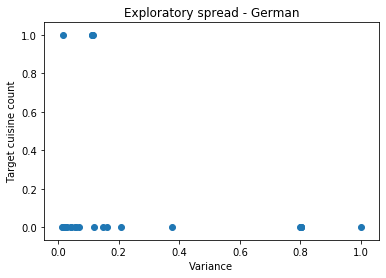

In [254]:
import matplotlib.pyplot as plt
x = df_norm['variance']
y = df_norm[tcuisine]

plt.scatter(x, y)
plt.xlabel('Variance')
plt.ylabel('Target cuisine count')
plt.title('Exploratory spread - German')
plt.show()

In [255]:
df_norm.head(32)

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude,Italian,Indian,...,Egyptian,Turkish,Persian,Thai,Total,Total_minus,rest_pot,variance,metric,Cluster
PostalCode,,,,,,,,,,,,,,,,,,,,,
M4E,M4E,1.36000,0.609669,0.013576,East Toronto,The Beaches,43.676357,-79.293031,0,0,...,0,0,0,0.05,2.05,0.037963,0.351594,0.022747,2.035549,0
M4K,M4K,1.36000,0.768854,0.010765,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0,...,0,0,0,0.15,11.15,0.206481,0.051259,0.205726,2.243086,0
M4L,M4L,1.34000,0.794586,0.010263,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,6,...,0,0,0,0.10,6.10,0.112963,0.089327,0.117313,2.124453,0
M4M,M4M,0.89000,0.601027,0.009012,East Toronto,Studio District,43.659526,-79.340923,1,0,...,0,0,0,0.05,1.05,0.019444,0.455677,0.015073,2.100234,0
M4N,M4N,2.31000,0.373192,0.037671,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,...,0,0,0,0.00,2.00,0.037037,1.000000,0.029146,2.477046,0
M4P,M4P,0.96000,0.487828,0.011977,Central Toronto,Davisville North,43.712751,-79.390197,0,1,...,0,0,0,0.10,4.10,0.075926,0.155086,0.022599,1.753415,0
M4S,M4S,1.42000,0.645260,0.013393,Central Toronto,Davisville,43.704324,-79.388790,0,2,...,0,0,0,0.25,3.25,0.060185,0.218787,0.021508,1.959133,0
M4V,M4V,2.10000,0.444058,0.028781,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0,0,...,0,0,0,0.25,5.25,0.097222,0.291053,0.042737,1.903850,0
M4X,M4X,0.53000,0.506889,0.006363,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0,0,...,0,0,0,0.05,1.05,0.019444,0.321754,0.012417,1.866868,0


# 7. Regression analysis and deficit calculation

In this section we develop a multi-parameter linear regression model for the number of cuisines from our target depending on the following parameters:
* Per capita income
* Total population
* Diversity of world cuisines in the restaurants in the area
* The total number of restaurants not including our target cuisine in the area
* The potential for people to spend more on eating out calculated as income per capita per restaurant

We import the linear model from sklearn and define a new array from the df_norm frame containing our five parameters. There is only one label here: the number of restaurants from our target cuisine. We use our entire dataset for training. We discuss why this is chosen in the report.

We perform the fit and obtain coefficients. These are then used to calculate the "error" for each entry in our data set. In other words, we are using the training data as test data. This is then represented in a scatter plot where the x-axis is the index and the y-axis is the error.

The error shows no particular pattern and has a tendency towards being zero mean. This confirms the choice of a linear model. For further discussion of what the errors mean and how they can be interpreted refer to the report.

In [256]:
from sklearn import datasets, linear_model, metrics 

In [257]:

X= df_norm[['per_capita', 'Population', 'variance', 'rest_pot','Total_minus']].copy()
#to_numpy(copy=True)
y = df_norm[[tcuisine]]

In [258]:
# create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg.fit(X, y) 
  
# regression coefficients 
print('Coefficients: \n', reg.coef_) 

Coefficients: 
 [[-0.26709732 -0.32896363 -1.24708896 -0.00912372  0.88347343]]


Text(0.5, 1.0, 'Error versus predicted value - Thai')

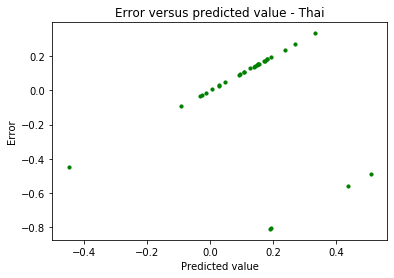

In [259]:
plt.scatter(reg.predict(X), reg.predict(X) - y, 
            color = "green", s = 10, label = 'Train data') 

plt.xlabel('Predicted value')
plt.ylabel('Error')
plt.title('Error versus predicted value - Thai')

In [260]:
X.head()
X2=X
X2['predicted']=reg.predict(X)
X2.head()
X2['target']=y
X2.head()
X2['error']=X2['predicted']-X2['target']
print(X2['error'].max())
print(X2['error'].min())
print(X2['error'].mean())
#X2.head(30)

0.33269995481373604
-0.8082454771146816
-3.642919299551295e-17


In [261]:
X2.head(36)

,per_capita,Population,variance,rest_pot,Total_minus,predicted,target,error
PostalCode,,,,,,,,
M4E,0.013576,0.609669,0.022747,0.351594,0.037963,0.095963,0.0,0.095963
M4K,0.010765,0.768854,0.205726,0.051259,0.206481,-0.032222,0.0,-0.032222
M4L,0.010263,0.794586,0.117313,0.089327,0.112963,-0.013263,0.0,-0.013263
M4M,0.009012,0.601027,0.015073,0.455677,0.019444,0.092284,0.0,0.092284
M4N,0.037671,0.373192,0.029146,1.000000,0.037037,0.152605,0.0,0.152605
M4P,0.011977,0.487828,0.022599,0.155086,0.075926,0.171988,0.0,0.171988
M4S,0.013393,0.645260,0.021508,0.218787,0.060185,0.106693,0.0,0.106693
M4V,0.028781,0.444058,0.042737,0.291053,0.097222,0.174359,0.0,0.174359
M4X,0.006363,0.506889,0.012417,0.321754,0.019444,0.128494,0.0,0.128494


# 8. Clustering

First, we apply a silhouette analysis to determine the optimal number of clusters. The first cell will determine clusters for the current target cuisine to be automatically used below. The next non-markup cell contains a loop that generates and prints the optimal clusters for all cuisines in our list. Do NOT run this cell every time because it is computationally intensive.

The obtained optimal value for the target cuisine is used in K-means clustering to determine the assignment of each postal code to one of the optimal_value_c clusters. This assignment is printed for illustration, but will be visualized in the next section.



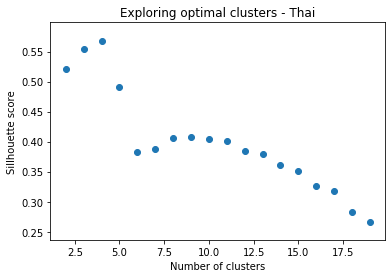

4


In [262]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans 
indices = []
scores = []
Xc = df_norm[['per_capita', 'Population', 'variance', 'rest_pot','Total_minus',tcuisine]].copy()
for tclusters in range(2, 20) :
    kmeans = KMeans(n_clusters = tclusters, init = "k-means++", random_state = 0).fit_predict(Xc)
    score = silhouette_score(Xc, kmeans)
    indices.append(tclusters) 
    scores.append(score)
import matplotlib.pyplot as plt
x = indices
y = scores

plt.scatter(x, y)
plt.xlabel('Number of clusters')
plt.ylabel('Sillhouette score')
plt.title('Exploring optimal clusters - Thai')
plt.show()
optimal_value_c = np.argmax(scores) + 2
print(optimal_value_c)

Silhouette to obtain ALL optimal clusters. Do not run every time. This is just run one time.

In [250]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans 

cuisinelist=['Italian', 'Indian', 'Chinese', 'Japanese', 'Korean', 'French', 'Greek', 'Brazilian', 'Mexican', 'Spanish', 'German', 'Moroccan', 'Turkish', 'Persian', 'Thai']

for mycuisine in cuisinelist:
    indices = []
    scores = []
    Xc = df_norm[['per_capita', 'Population', 'variance', 'rest_pot','Total_minus',mycuisine]].copy()
    for tclusters in range(2, 20) :
        cluster_dataset2 = StandardScaler().fit_transform(Xc)
        kmeans = KMeans(n_clusters = tclusters, init = "k-means++", random_state = 0).fit_predict(cluster_dataset2)
        score = silhouette_score(cluster_dataset2, kmeans)
        indices.append(tclusters)
        scores.append(score)
    x = indices
    y = scores
    optimal_value = np.argmax(scores) + 2
    print("Optimal value for {} is {}".format(mycuisine,optimal_value))


Optimal value for Italian is 2
Optimal value for Indian is 2
Optimal value for Chinese is 2
Optimal value for Japanese is 2
Optimal value for Korean is 2
Optimal value for French is 3
Optimal value for Greek is 2
Optimal value for Brazilian is 3
Optimal value for Mexican is 2
Optimal value for Spanish is 2
Optimal value for German is 4
Optimal value for Moroccan is 2
Optimal value for Turkish is 2
Optimal value for Persian is 4
Optimal value for Thai is 2


In [242]:
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

In [263]:
from sklearn.preprocessing import StandardScaler

Xc = df_norm[['per_capita', 'Population', 'variance', 'rest_pot','Total_minus',tcuisine]].copy()
#X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(Xc)
cluster_dataset

array([[-0.21584368,  0.45301126, -0.62474981,  0.36258582, -0.76351552,
        -0.37796447],
       [-0.23196334,  0.96123687, -0.03034181, -0.67877405, -0.27205725,
        -0.37796447],
       [-0.23484112,  1.04338926, -0.31754906, -0.5467785 , -0.54478959,
        -0.37796447],
       [-0.24201754,  0.42541987, -0.64967797,  0.72347652, -0.81752192,
        -0.37796447],
       [-0.07766153, -0.30198241, -0.60396235,  2.61082193, -0.76621584,
        -0.37796447],
       [-0.22501636,  0.06401154, -0.62522914, -0.31877342, -0.65280239,
        -0.37796447],
       [-0.21689265,  0.56664115, -0.62877361, -0.09790077, -0.69870784,
        -0.37796447],
       [-0.12864394, -0.07573302, -0.55981224,  0.15266882, -0.59069503,
        -0.37796447],
       [-0.25720717,  0.12486804, -0.65830635,  0.25912145, -0.81752192,
        -0.37796447],
       [-0.24523899,  0.87488748, -0.33051752, -0.77103487,  0.05468148,
         2.64575131],
       [-0.24658269,  1.69920937, -0.63592996, -0.

In [264]:
num_clusters = optimal_value_c

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(len(labels))
print(labels)

32
[0 0 0 0 0 0 0 0 0 2 0 1 1 2 2 1 0 1 1 0 0 0 1 0 3 0 0 0 0 0 0 2]


# 9. Data visualization and insights

First, obtain location information for Toronto and generate and print a map of the city. We then merge the label information obtained in section 8 with the main data frame. We use the method used in Week 3 to assign a different color to each cluster and display them on the map. Note that the first map displays all neighborhoods with the same color just for illustration.

In [265]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [266]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post, borough, neigh in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['PostalCode'], df_merged['Borough'], df_merged['Neighborhood']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, long],radius=5,popup=popup,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(map_toronto)
    
map_toronto

In [267]:
df_merged_cluster = df_merged
df_merged_cluster['Cluster'] = labels
df_merged_cluster.head(35)

,PostalCode,Income,Population,per_capita,Borough,Neighborhood,Latitude,Longitude,Italian,Indian,...,Egyptian,Turkish,Persian,Thai,Total,Total_minus,rest_pot,variance,metric,Cluster
PostalCode,,,,,,,,,,,,,,,,,,,,,
M4E,M4E,1.36000,0.609669,0.013576,East Toronto,The Beaches,43.676357,-79.293031,0,0,...,0,0,0,0.05,2.05,0.037963,0.351594,0.022747,2.035549,0
M4K,M4K,1.36000,0.768854,0.010765,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0,...,0,0,0,0.15,11.15,0.206481,0.051259,0.205726,2.243086,0
M4L,M4L,1.34000,0.794586,0.010263,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,6,...,0,0,0,0.10,6.10,0.112963,0.089327,0.117313,2.124453,0
M4M,M4M,0.89000,0.601027,0.009012,East Toronto,Studio District,43.659526,-79.340923,1,0,...,0,0,0,0.05,1.05,0.019444,0.455677,0.015073,2.100234,0
M4N,M4N,2.31000,0.373192,0.037671,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,...,0,0,0,0.00,2.00,0.037037,1.000000,0.029146,2.477046,0
M4P,M4P,0.96000,0.487828,0.011977,Central Toronto,Davisville North,43.712751,-79.390197,0,1,...,0,0,0,0.10,4.10,0.075926,0.155086,0.022599,1.753415,0
M4S,M4S,1.42000,0.645260,0.013393,Central Toronto,Davisville,43.704324,-79.388790,0,2,...,0,0,0,0.25,3.25,0.060185,0.218787,0.021508,1.959133,0
M4V,M4V,2.10000,0.444058,0.028781,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0,0,...,0,0,0,0.25,5.25,0.097222,0.291053,0.042737,1.903850,0
M4X,M4X,0.53000,0.506889,0.006363,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0,0,...,0,0,0,0.05,1.05,0.019444,0.321754,0.012417,1.866868,0


In [269]:
# create map
map_k = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i+x+(i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(df_merged_cluster['Latitude'], df_merged_cluster['Longitude'], df_merged_cluster['PostalCode'], df_merged_cluster['Borough'], df_merged_cluster['Neighborhood'], df_merged_cluster['Cluster']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_k)
       
map_k